Este dataset busca encontrar o preço de um carro dada algumas variáveis, Será utilizado uma regressão usando o algoritmo KNN

In [291]:
#imports basicos
import pandas as pd
import numpy as np
import plotly.express as px

#analise exploratoria
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

#preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#KNN
from sklearn.neighbors import KNeighborsRegressor
from scipy.spatial.distance import mahalanobis

#avaliação do modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#métodos de avaliação avançados
from sklearn.model_selection import GridSearchCV, StratifiedKFold


## IMPORTANDO O ARQUIVO

In [292]:
car = pd.read_csv(r'Car details v3.csv')
car.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


## VERIFICAÇÃO INICIAL DOS DADOS

In [293]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [294]:
car.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


## TRATAMENTO INICIAL

Primeiramente vamos tirar as unidades das colunas mileage, engine e max_power, e colocar as unidades no nome das colunas 

In [295]:
#função para remover o sufixo
def remove_suffix(value):
    if isinstance(value, str) and value.strip():
        value = value.split(" ")[0]
        try:
            return float(value)
        except ValueError:
            try:
                return int(value)
            except ValueError:
                return 0      
    else:
        return 0

In [296]:
col = ['mileage', 'engine', 'max_power']
car[col] = car[col].applymap(remove_suffix)

In [297]:
car.rename(columns={"mileage": "mileage (kmpl)", "engine": "engine (CC)", "max_power": "max_power (bhp)"}, inplace=True)

In [298]:
car.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage (kmpl),engine (CC),max_power (bhp),torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


A coluna torque podemos remover pois não precisamos para nossa análises

In [299]:
car = car.drop(["torque"], axis=1)

In [300]:
car.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage (kmpl),engine (CC),max_power (bhp),seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0


## ANÁLISE EXPLORATÓRIA

1 - Ser o primeiro, segundo ou terceiro dono influencia no preço do carro? E o tipo de marcha? E o tipo de vendedor? E o combustivel?

In [301]:
#calculando preço médio de venda
mean_selling_price_by_owner = car.groupby('owner')['selling_price'].mean()
mean_selling_price_by_transmission = car.groupby('transmission')['selling_price'].mean()
mean_selling_price_by_seller_type = car.groupby('seller_type')['selling_price'].mean()
mean_selling_price_by_fuel = car.groupby('fuel')['selling_price'].mean()

# fazer um barplot sendo media do preço x numero de donos, tipo de marcha, tipo de vendedor e combustivel
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Bar(x=mean_selling_price_by_owner.index, y=mean_selling_price_by_owner.values, name='Preço médio de venda',  marker_color='blue', showlegend=False), row=1, col=1)
fig.add_trace(go.Bar(x=mean_selling_price_by_transmission.index, y=mean_selling_price_by_transmission.values, name='Preço médio de venda',  marker_color='green', showlegend=False), row=1, col=2)
fig.add_trace(go.Bar(x=mean_selling_price_by_seller_type.index, y=mean_selling_price_by_seller_type.values, name='Preço médio de venda',  marker_color='red', showlegend=False), row=2, col=1)
fig.add_trace(go.Bar(x=mean_selling_price_by_fuel.index, y=mean_selling_price_by_fuel.values, name='Preço médio de venda',  marker_color='orange', showlegend=False), row=2, col=2)

#Dando update no layout do subplot
fig.update_layout(title_text="Investigação do preço dos carros", height=600, width=800, barmode='group',
                  title_x=0.5, yaxis_title="Mean Selling Price")

#Ordenando os dados e a escala de cor para cada grafico
def sort_and_set_colors(trace, color_scale):
    sorted_idx = trace.y.argsort()[::-1]  # Reverse the order
    trace.x = trace.x[sorted_idx]
    trace.y = trace.y[sorted_idx]
    trace.marker.color = trace.y
    trace.marker.colorscale = color_scale

sort_and_set_colors(fig.data[0], 'RdBu')
sort_and_set_colors(fig.data[1], 'Jet')
sort_and_set_colors(fig.data[2], 'Reds')
sort_and_set_colors(fig.data[3], 'Oranges')

fig.show()


Podemos ver que carros de test drive possuem um preço medio bem mais alto, sugerindo talvez que eles possam ter uma quilometragem menor? Será verificado mais abaixo. Carros com câmbio automático são mais caros devido a sua complexidade, e carros vendidos por revendedor possui um preço maior, pois além de haver sua comissão ele tenta um preço mais alto possível. E vemos também que carros a diesel são mais caros.

2 - Quantidade de km dirigidos influencia muito no preço do carro?

In [302]:
#fazer um scatterplot de preço x km dirigidos, podendo colocar cores sendo qtde de donos
fig = px.scatter(car, x="km_driven", y="selling_price", color="owner")
fig.show()

Podemos observar que quanto mais quilômetros rodados menor o preço do carro, informação que já esperávamos.

3 - E o quanto a idade do carro influencia?

In [303]:
#scatterplot de preço x ano
mean_selling_price_by_year = car.groupby('year')['selling_price'].mean().reset_index()
fig = px.bar(mean_selling_price_by_year, x="year", y="selling_price")

fig.show()

Podemos ver que quanto mais novo o carro maior a tendência dele possuir um preço maior. Um preço maior em 1983 pode-se traduzir por pessoas que gostam de carros antigos e estão dispostas a pagar um pouco mais. E a tendência de 202 merece ser mais investigada.

4 - Qual distribuição dos preços dos carros?

In [304]:
#histplot dos preços dos carros
#filtrando os valores muito altos para o gráfico ficar de melhor visualização
filtered_car = car.query('selling_price < 4000000')

#calculando o histograma manualmente
hist, edges = np.histogram(filtered_car['selling_price'], bins=80)
max_bin_index = np.argmax(hist)

fig = go.Figure(data=[go.Bar(x=edges, y=hist, marker=dict(color='blue'))])

colors = ['red' if i == max_bin_index else 'blue' for i in range(len(hist))]
fig.data[0].marker.color = colors

fig.show()

Podemos ver que a maior parte dos carros custa entre 250 e 300 mil.

5 - Carros a gasolina ou a diesel gastam mais?

In [305]:
#barplot da media de consumo de combustivel por tipo de combustivel
mean_fuel_comsumption = car.groupby('fuel')['mileage (kmpl)'].mean().reset_index()
fig = px.bar(mean_fuel_comsumption, x="fuel", y="mileage (kmpl)", text_auto=True)

fig.show()

Podemos ver que carros com CNG possuem maior quilometragem, enquanto LPG possuem a menor.

6 - Relação a quantidade de donos e quilometragem do carro

## SPLIT DOS DADOS

Primeiramente vamos selecionar as colunas que irão para o modelo final e fazer o split dos dados

In [306]:
car.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage (kmpl),engine (CC),max_power (bhp),seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0


In [307]:
car = car.drop('name', axis=1)

In [308]:
car.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage (kmpl),engine (CC),max_power (bhp),seats
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0


In [309]:
car['seats'].fillna(0, inplace=True)

A coluna name não importa para nossa modelagem. Após isso vamos fazer o split dos dados, para posterior tratamento de forma a evitar data leakage:

In [310]:
#criando os dataframes X e y:
X = car.drop('selling_price', axis=1)
X.rename(columns={"transmission" : "manual_transmission"}, inplace=True)
y = car['selling_price']

In [311]:
X.shape

(8128, 10)

In [312]:
#para evitar problemas no imputer fazemos essa transformação aqui
X['seats'] = X['seats'].replace(['nan', 'N/A'], np.nan)

In [313]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 8128 non-null   int64  
 1   km_driven            8128 non-null   int64  
 2   fuel                 8128 non-null   object 
 3   seller_type          8128 non-null   object 
 4   manual_transmission  8128 non-null   object 
 5   owner                8128 non-null   object 
 6   mileage (kmpl)       8128 non-null   float64
 7   engine (CC)          8128 non-null   float64
 8   max_power (bhp)      8128 non-null   float64
 9   seats                8128 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 635.1+ KB


In [314]:
y.shape

(8128,)

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

## FEATURE ENGINEERING

Primeiramente devemos tratar a coluna transmission de modo a ter apenas valores 0 e 1.

In [316]:
#transformer do genero
class TransmissionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['manual_transmission'] = X_transformed['manual_transmission'].map({'Manual': 1, 'Automatic': 0})
        
        # Handle missing values
        X_transformed['manual_transmission'] = X_transformed['manual_transmission'].fillna(-1)  # Replace NaN with a desired value
        
        return X_transformed

Para as outras variáveis categóricas devemos fazer one hot encoding. Porém isso vai aumentar demasiamente a dimensionalidade, o que requerirá algum processo de diminuição de dimensionalidade.

Após isso devemos verificar se não há valores nulos no dataset:

In [317]:
colunas = X.columns

for col in colunas:
    a = X[col].isnull().sum()
    print(f"Column: {col}, Null Count: {a}")

Column: year, Null Count: 0
Column: km_driven, Null Count: 0
Column: fuel, Null Count: 0
Column: seller_type, Null Count: 0
Column: manual_transmission, Null Count: 0
Column: owner, Null Count: 0
Column: mileage (kmpl), Null Count: 0
Column: engine (CC), Null Count: 0
Column: max_power (bhp), Null Count: 0
Column: seats, Null Count: 0


Agora precisamos fazer uma checagem e tratamento nos outliers, pois isso impactaria na performance do KNN

In [319]:
#criação dos thresholds para os outliers, coluna a coluna, no caso limite inferior são 5% dos dados e superior 95%
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [320]:
#checagem coluna a coluna quantos outliers existem caso existam
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [321]:
#pegando apenas as colunas numéricas para checagem de outliers:
numeric_cols = X.drop(['fuel','seller_type','manual_transmission','owner'], axis=1)

In [322]:
for col in numeric_cols:
    print(col, f'-----There is outliers: {check_outlier(X, col, q1=0.05, q3=0.95)}')

year -----There is outliers: True
km_driven -----There is outliers: True
mileage (kmpl) -----There is outliers: False
engine (CC) -----There is outliers: False
max_power (bhp) -----There is outliers: True
seats -----There is outliers: True


In [323]:
#vamos plotar boxplots para inspecionar estes outliers:
fig = make_subplots(rows=1, cols=4)

fig.add_trace(go.Box(y=X['year'], name='Ano',  marker_color='indianred'), row=1, col=1)
fig.add_trace(go.Box(y=X['km_driven'], name='Km percorrido',  marker_color='lightseagreen'), row=1, col=2)
fig.add_trace(go.Box(y=X['max_power (bhp)'], name='Potência máxima',  marker_color='sienna'), row=1, col=3)
fig.add_trace(go.Box(y=X['seats'], name='Bancos',  marker_color='steelblue'), row=1, col=4)

#Dando update na figura para incluir os titulos no grafico
fig.update_layout(
    title_text="Box Plots",
    height=400,
    width=1000,
    title_x=0.5,
    yaxis_title="Value"
)

fig.show()

No caso acima, fizemos uma checagem de outliers e consideramos que tudo abaixo de 5% dos dados e tudo acima de 95% dos dados são outliers. Porém não removeremos os outliers de todas as variáveis, pois pode haver perda de informação, então será removido apenas os outliers dos km percorridos e a potência máxima.

agora será criado um transformer para remoção de outliers:

In [326]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, q1=0.05, q3=0.95):
        self.q1 = q1
        self.q3 = q3
        self.thresholds = {}
        self.outlier_indices_ = []

    def fit(self, X, y=None):
        self.outlier_indices_ = []  # Reset the outlier indices list
        for col in X.columns:
            low_limit, up_limit = outlier_thresholds(X, col, self.q1, self.q3)
            self.thresholds[col] = (low_limit, up_limit)
            outlier_indices = (X[col] < low_limit) | (X[col] > up_limit)
            self.outlier_indices_.extend(np.where(outlier_indices)[0])
        return self

    def transform(self, X):
        for col, (low_limit, up_limit) in self.thresholds.items():
            X[col] = X[col].clip(lower=low_limit, upper=up_limit)
        return X

    def outlier_indices_(self):
        return np.array(self.outlier_indices_)

Com isso temos o nosso column transformer para aplicar tanto nos dados de treino e teste:

In [328]:
preprocessor = ColumnTransformer(
    transformers=[
        ('inpute', imputer, ['seats']),
        ('Transformação da coluna transmissão', TransmissionTransformer(), ['manual_transmission']),
        ('One hot encoder', OneHotEncoder(), ['fuel','seller_type','owner']),
        ('remoçao de outliers', OutlierRemover(), ['km_driven','max_power (bhp)']),
        ('padronização', StandardScaler(), ['year','km_driven','mileage (kmpl)','engine (CC)','max_power (bhp)','seats'])
    ],
    remainder='passthrough'
)

agora iremos aplicar as transformações tanto nos dados de treino quanto de teste:

In [329]:
X_traint = preprocessor.fit_transform(X_train)

In [330]:
X_testt = preprocessor.fit_transform(X_test)

In [331]:
#resetando os indices dos dados de treino para evitar erros:
#Instanciando o OutlierRemover transformer
outlier_remover = OutlierRemover(q1=0.05, q3=0.95)

#Obtendo os indices dos outliers para remover de y também
outlier_indices = outlier_remover.outlier_indices_

#Removendo as linhas correspondentes de y_train
y_train_no_outliers = np.delete(y_train, outlier_indices, axis=0)

#fazendo o mesmo para y_test
y_test_no_outliers = np.delete(y_test, outlier_indices, axis=0)

In [332]:
X_traint.shape

(6096, 22)

In [333]:
y_train.shape

(6096,)

In [334]:
X_testt.shape

(2032, 22)

In [335]:
y_test.shape

(2032,)

In [336]:
pd.DataFrame(X_traint)

Vemos que o modelo possui muitas variáveis agora depois do one hot encode. Portanto precisamos diminuir o número de dimensões antes de aplicar o KNN.

aplicar padronização no columntransformer

## MODELAGEM

In [338]:
#instanciando o modelo
knn = KNeighborsRegressor()

vamos fazer o cross validation para obter o valor ótimo de k

In [339]:
#obtendo os valores de k a testar
k = np.arange(26)
params = {'n_neighbors':k}

In [340]:
#fazendo cross validation com os valores de k:
modeloKNN = GridSearchCV(knn, params, cv=10, scoring='r2')

In [341]:
modeloKNN.fit(X_traint, y_train)
modeloKNN.best_params_

c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:427: FitFailedWarning:


10 fits failed out of a total of 260.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 734, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1141, in wrapper
    estimator._validate_params()
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.

{'n_neighbors': 2}

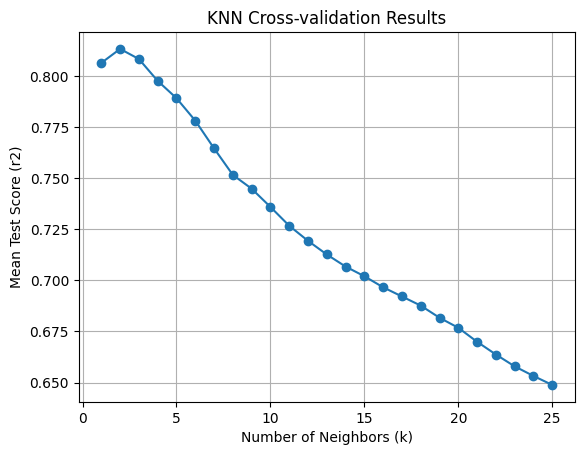

In [342]:
#Extraindo os resultados obtidos pelo cross validation
cv_results = modeloKNN.cv_results_

#Pegando os valores de k e seus scores de teste
k_values = cv_results['param_n_neighbors'].data.astype(int)
mean_test_scores = cv_results['mean_test_score']

#Plotando k versus seu score
plt.plot(k_values, mean_test_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score (r2)')
plt.title('KNN Cross-validation Results')
plt.grid(True)
plt.show()

rodar o modelo com metrica normal, porém depois testar com mahalonobis distance